In [1]:
import tensorflow as tf
import os
import numpy as np
import tensorflow_addons as tfa
import matplotlib.pyplot as plt

c:\Users\Avishi\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
c:\Users\Avishi\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.12.0 and strictly below 2.15.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.11.0 and is not supported. 
Some things might work, some things might not.
If you were to encoun

In [29]:
# Directory containing texture images
texture_dir = r"C:\Users\Avishi\Downloads\old_image_textures"

# List all image files in the directory
texture_files = [os.path.join(texture_dir, file) for file in os.listdir(texture_dir)
                 if os.path.isfile(os.path.join(texture_dir, file))]

In [30]:
print(f"Found {len(texture_files)} image files.")

Found 65 image files.


In [31]:
# Function to load and preprocess images
def load_and_preprocess_image(file_path):
    """Load and preprocess an image to a fixed size."""
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)  # Assuming JPEG images
    img = tf.image.resize(img, [224, 224])  # Resize to target shape
    img = img / 255.0  # Normalize to [0, 1]
    return img

# Create a TensorFlow dataset of file paths
file_paths_dataset = tf.data.Dataset.from_tensor_slices(tf.constant(texture_files, dtype=tf.string))

# Map the dataset to load and preprocess each image
dataset = file_paths_dataset.map(
    load_and_preprocess_image,
    num_parallel_calls=tf.data.AUTOTUNE
)

In [32]:
# Augmentation function
def augment_image(image):
    """Apply random augmentations to the image."""
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)

    # Rotate by a random angle (in degrees)
    angle_rad = tf.random.uniform([], -15, 15, dtype=tf.float32) * tf.constant(np.pi / 180)
    image = tfa.image.rotate(image, angle_rad)
    return image

In [33]:
# Apply the augmentation function to the dataset
augmented_dataset = dataset.map(augment_image, num_parallel_calls=tf.data.AUTOTUNE)

# Repeat, shuffle, and batch the dataset for training
augmented_dataset = augmented_dataset.repeat(10).shuffle(buffer_size=20).batch(15)

Processing batch 1


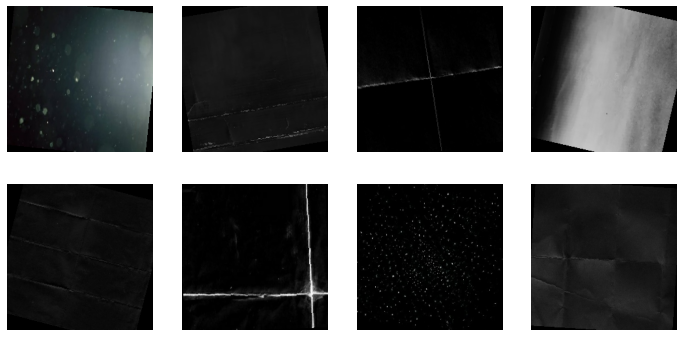

In [34]:
for batch_num, batch in enumerate(augmented_dataset.take(1)):
    print(f"Processing batch {batch_num + 1}")
    fig, axs = plt.subplots(2, 4, figsize=(12, 6))
    axs = axs.flatten()
    for img, ax in zip(batch, axs):
        ax.imshow(img)
        ax.axis('off')
    plt.show()

In [37]:
total_images = sum(1 for _ in augmented_dataset.unbatch())
print(f"Actual total size of the augmented dataset: {total_images} images.")

Actual total size of the augmented dataset: 650 images.


In [38]:
class StyleContentExtractor(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super(StyleContentExtractor, self).__init__()
        self.vgg = self.build_vgg(style_layers, content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers

    def build_vgg(self, style_layers, content_layers):
        """Builds a VGG model that returns intermediate style and content features."""
        vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
        vgg.trainable = False
        output_layers = style_layers + content_layers
        outputs = [vgg.get_layer(name).output for name in output_layers]
        return tf.keras.models.Model([vgg.input], outputs)

    def call(self, x):
        """Forward pass to get both style and content outputs."""
        x = tf.keras.applications.vgg19.preprocess_input(x * 255.0)
        outputs = self.vgg(x)
        style_outputs = outputs[:len(self.style_layers)]
        content_outputs = outputs[len(self.style_layers):]

        style_dict = {name: output for name, output in zip(self.style_layers, style_outputs)}
        content_dict = {name: output for name, output in zip(self.content_layers, content_outputs)}

        return {'style': style_dict, 'content': content_dict}

**Style Layers:**

block1_conv1: Fine textures.

block2_conv1: Basic fold patterns.

block3_conv1: Medium fold patterns.

block4_conv1: Broad fold patterns.

**Content Layer:**

block4_conv2: Captures paper fold patterns.

In [50]:
# Example layers for style and content features
style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1']
content_layers = ['block4_conv2']

# Instantiate the extractor
extractor = StyleContentExtractor(style_layers, content_layers)

In [51]:
# Calculate the Gram matrix to capture style features
def gram_matrix(tensor):
    """Calculates the Gram matrix of an input tensor for style representation."""
    result = tf.linalg.einsum('bijc,bijd->bcd', tensor, tensor)
    input_shape = tf.shape(tensor)
    num_locations = tf.cast(input_shape[1] * input_shape[2], tf.float32)
    return result / num_locations

# Adjusted style-content loss function
def style_content_loss(outputs, style_targets, content_targets, style_weight=1e-3, content_weight=1e-4):
    """Modified loss function emphasizing texture over color."""
    # Extract style and content outputs
    style_outputs = outputs['style']
    content_outputs = outputs['content']

    # Style (texture) loss using Gram matrix
    style_loss = tf.add_n([
        tf.reduce_mean((gram_matrix(style_outputs[name]) - gram_matrix(style_targets[name]))**2)
        for name in style_outputs.keys()
    ])
    num_style_layers = len(style_outputs)
    style_loss *= style_weight / num_style_layers

    # Content loss (minimized, since we focus mainly on texture)
    content_loss = tf.add_n([
        tf.reduce_mean((content_outputs[name] - content_targets[name])**2)
        for name in content_outputs.keys()
    ])
    num_content_layers = len(content_outputs)
    content_loss *= content_weight / num_content_layers

    # Total loss
    loss = style_loss + content_loss
    return loss, style_loss

In [52]:
# Training step function
@tf.function
def train_step(image, style_targets, content_targets, extractor, opt):
    """Training step function with the new loss function."""
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss, style_loss = style_content_loss(outputs, style_targets, content_targets)

    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))
    return loss, style_loss

# Optimizer and clipping function
opt = tf.optimizers.Adam(learning_rate=0.02)

def clip_0_1(image):
    """Clip image values between 0 and 1."""
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

# Compute the target feature maps for both style and content
def compute_targets(style_image, content_image, extractor):
    """Compute the target feature maps for both style and content."""
    style_targets = extractor(style_image)['style']
    content_targets = extractor(content_image)['content']
    return style_targets, content_targets

In [60]:
# Assume style_image and content_image are your reference images preprocessed to [0, 1] range
style_image = tf.convert_to_tensor(np.random.rand(1, 224, 224, 3), dtype=tf.float32)
content_image = tf.convert_to_tensor(np.random.rand(1, 224, 224, 3), dtype=tf.float32)

style_targets, content_targets = compute_targets(style_image, content_image, extractor)

# Assume the generated image is initialized randomly or as the content image
# generated_image = tf.Variable(tf.random.uniform(content_image.shape, minval=0.0, maxval=1.0))
generated_image = tf.Variable(content_image)


# Training Loop
epochs = 100
steps_per_epoch = 1

In [61]:
for epoch in range(epochs):
    for step in range(steps_per_epoch):
        train_step(generated_image, style_targets, content_targets, extractor, opt)
    print(f"Training Epoch {epoch + 1}/{epochs}")

Training Epoch 1/100
Training Epoch 2/100
Training Epoch 3/100
Training Epoch 4/100
Training Epoch 5/100
Training Epoch 6/100
Training Epoch 7/100
Training Epoch 8/100
Training Epoch 9/100
Training Epoch 10/100
Training Epoch 11/100
Training Epoch 12/100
Training Epoch 13/100
Training Epoch 14/100
Training Epoch 15/100
Training Epoch 16/100
Training Epoch 17/100
Training Epoch 18/100
Training Epoch 19/100
Training Epoch 20/100
Training Epoch 21/100
Training Epoch 22/100
Training Epoch 23/100
Training Epoch 24/100
Training Epoch 25/100
Training Epoch 26/100
Training Epoch 27/100
Training Epoch 28/100
Training Epoch 29/100
Training Epoch 30/100
Training Epoch 31/100
Training Epoch 32/100
Training Epoch 33/100
Training Epoch 34/100
Training Epoch 35/100
Training Epoch 36/100
Training Epoch 37/100
Training Epoch 38/100
Training Epoch 39/100
Training Epoch 40/100
Training Epoch 41/100
Training Epoch 42/100
Training Epoch 43/100
Training Epoch 44/100
Training Epoch 45/100
Training Epoch 46/1